In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generate binary classification data with $p(x=1) = \frac{1}{1+e^{25.-0.5x}}$

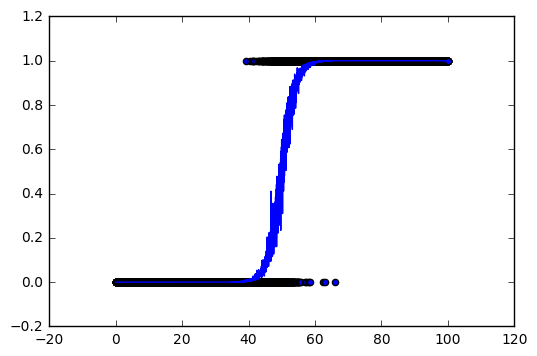

In [2]:
xi = 0.0
xf = 100.0
n = 10000

def logistic(beta,x):
    x = np.c_[np.ones_like(x), x]
    beta_x = (beta*x).sum(axis=1)  + np.random.randn(x.shape[0]) * 0.3
    return 1./(1. + np.exp(-beta_x))

beta = np.array([-25.,0.5])

x = np.linspace(xi,xf,n)

p = logistic(beta, x)

y = np.zeros_like(x)
for i in range(len(x)):
    if np.random.random() < p[i]:
        y[i] = 1.

Data = np.c_[x,y]
plt.scatter(x, y)
plt.plot(x, p)

Below, the $U(data, beta)$ is the potential energy. For logistic regression (binary, y = \{0,1\}), this is 
$$\sum_{x,y \in Data} log(1+e^{(-1)^y (\beta_0 + \beta_1 x_1 +\cdots)}) $$, the $p(\beta)$ is the prior distribution of $\beta$.

$gradU\_exact(data, beta)$ is the gradient of the potential energy. 
$$\frac{\partial U(\beta)}{\partial \beta_i} = \sum_{x,y \in Data} \frac{(-1)^y x_i }{1+e^{(-1)^{y+1} (\beta_0 + \beta_1 x_1 +\cdots)}} $$

$gradU\_SG(data, beta)$ uses only minibatch of the total data to compute the summation appearing in the gradient, plus a normal noise.

Here we are just using a uniform prior, i.e. $log(\beta) = 0$

In [3]:
def U(data, beta):
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    pdata = (np.log(1. + np.exp( ((-1.)**dataY) * beta_X) )).sum() 
    return pdata

def gradU_exact(data, beta):
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    
    der_temp = ((-1.)**dataY)/(1. + (np.exp( ((-1.)**(dataY+1.)) * beta_X )) )
    ddata = (der_temp[:, None] * dataX).sum(axis=0)
    
    
    return ddata

def gradU(data, minibatch, beta):
    '''using minibatch of the original data to compute the gradient'''
    
    dataX = data[:,:-1] 
    dataY = data[:,-1]
    dataX = np.c_[np.ones_like(dataX[:,0]), dataX]
    beta_X = (beta*dataX).sum(axis=1)
    
    der_temp = ((-1.)**dataY)/(1. + (np.exp( ((-1.)**(dataY+1.)) * beta_X )) )
    ddata = (der_temp[:, None] * dataX)
    ##### using minibatch of the data #####
    ddata = ddata[np.random.choice(ddata.shape[0], int(minibatch * ddata.shape[0]), replace=False),:].sum(axis=0) 
    #################################
    
    
    return (1./minibatch)*ddata

In [4]:
import functools

gradU_data = functools.partial(gradU, Data)

U_data = functools.partial(U, Data)

### Doing a MLE for comparison

In [5]:
from scipy.optimize import minimize

minimize(U_data, [-20., 0.4])

      fun: 668.2661040155622
 hess_inv: array([[  2.82465425e-05,  -3.84705795e-06],
       [ -3.84705795e-06,   1.68678023e-06]])
      jac: array([ 0.00010681,  0.00510406])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 368
      nit: 12
     njev: 89
   status: 2
  success: False
        x: array([-24.50905383,   0.49224874])

## Using SGHMC

In [6]:
def sghmc_vectorNew(gradU, eta, L, alpha, x, V):
    beta = 0.5 * V * eta
    p = np.random.randn(len(x)) * np.sqrt( eta )
    momentum = 1. - alpha
    try:
        sigma = np.sqrt( 2. * eta * (alpha-beta) )
    except:
        raise ValueError('eta too big')
    for i in range(L):
        p = p * momentum - gradU( x ) * eta + np.random.randn(len(p)) * sigma
        x += p
    return x.copy()

In [7]:
nsample = 10000
minibatch = 0.1 # using 10% of the original data to compute gradient
gradU_data_SGHMC = functools.partial(gradU_data, minibatch)

V = 1./minibatch
etaSGHMC = (0.001)**2
alpha = 0.01
L = 50

In [8]:
%%time

samplesSGHMC = []
b = np.array([-1., 1])
for i in range(nsample):
    b = sghmc_vectorNew(gradU_data_SGHMC, etaSGHMC, L, alpha, b.copy(), V)
    samplesSGHMC.append(b)


CPU times: user 10min 19s, sys: 116 ms, total: 10min 19s
Wall time: 10min 21s


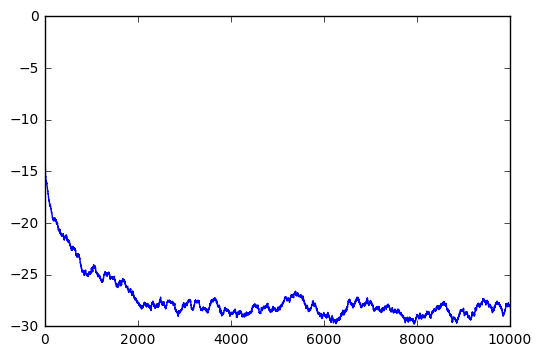

In [9]:
samplesSGHMC = np.array(samplesSGHMC)
plt.plot(samplesSGHMC[:,0])
pass

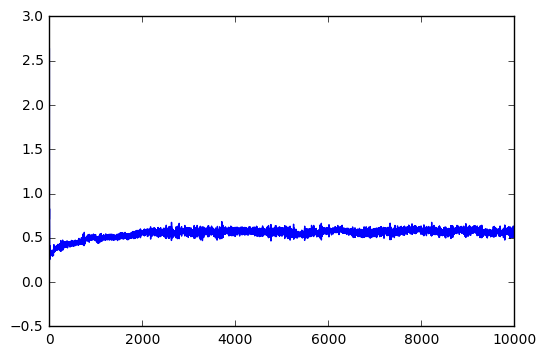

In [11]:
plt.plot(samplesSGHMC[:,1])
pass

## Using HMC

In [15]:
def hmc_vector(U, gradU, m, dt, nstep, x, MH):
    p = np.random.randn(len(x)) * np.sqrt(m)
    oldX = x.copy()
    oldEnergy = 0.5 * (1./m) * p.dot(p)  + U(x)
    for i in range(nstep):
        p -= gradU(x) * dt/2.
        x +=  1./m * p * dt
        p -= gradU(x) * dt/2.
    newEnergy = 0.5 * (1./m) * p.dot(p)  + U(x)
    
    if MH and np.random.random() > np.exp(oldEnergy - newEnergy): # Metropolis-Hastings
        x = oldX.copy()
    return x.copy()

In [16]:
minibatch = 1.
gradU_data_HMC = functools.partial(gradU_data, minibatch)

nsample = 10000
m = 1.
dt = 0.001
nstep = 50
MH=False

In [17]:
%%time


samplesHMC = []
b = np.array([-1.,1.])
for i in range(nsample):
    b = hmc_vector( U_data, gradU_data_HMC, m, dt, nstep, b.copy(), MH )
    samplesHMC.append(b)

    

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:50: RuntimeWarning: overflow encountered in exp


CPU times: user 27min 4s, sys: 432 ms, total: 27min 5s
Wall time: 27min 8s


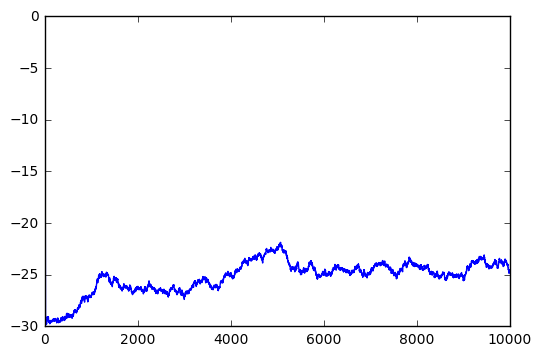

In [20]:
samplesHMC = np.array(samplesHMC)
plt.plot(samplesHMC[:,0])
pass

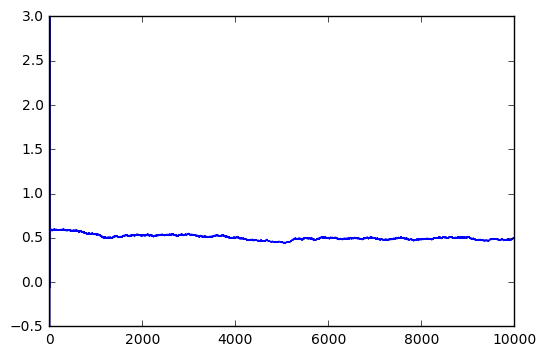

In [21]:
plt.plot(samplesHMC[:,1])
plt.ylim(-0.5,3.)
pass